## Solución por Elementos Finitos en 1D

Se solucionará el siguiente problema de condición de frontera:

\begin{equation}
    -\Delta u + u = f \quad \forall t \in [0,1] : u(0)=u(1)=0
\end{equation}



In [1]:
from ngsolve import *
import netgen.meshing as ngm
from matplotlib import pyplot as plt

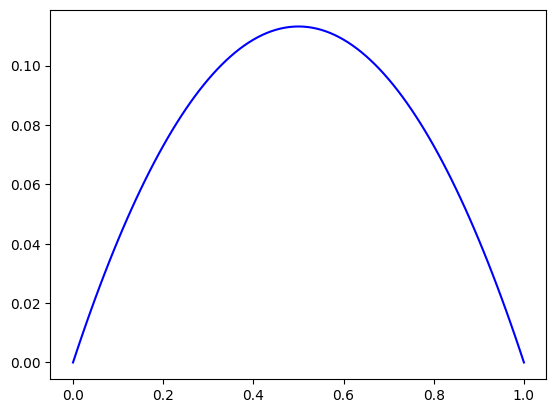

In [18]:
def main(N = 50, order = 1, hmax = 0.1):
    m = ngm.Mesh() 
    m.dim = 1

    pnums = []
    for i in range(N+1):
        pnums.append(m.Add( ngm.MeshPoint(ngm.Pnt(i/N, 0, 0) )))

    for i in range(0,N):
        m.Add (ngm.Element1D ([pnums[i],pnums[i+1]], index=1))
        
    # se añaden los objetos de borde
    m.Add (ngm.Element0D (pnums[0], index=1)) 
    m.Add (ngm.Element0D (pnums[N], index=2))

    m.SetMaterial(1, 'material') # define un material en el dominio para poder caracterizar posibles
                                 # heterogeneidades en las propiedades de este

    # se nombran los puntos para luego utilizar expresiones regulares (regex)
    m.SetBCName(0, 'left')
    m.SetBCName(1, 'right')

    mesh = Mesh(m) # se genera el objeto Mesh() del módulo ngsolve
    
    # se utiliza el espacio de funciones H1 y se añade el tipo de condición de borde
    fes = H1(mesh, order=order, dirichlet='left|right') 
    # las condiciones de borde de dirichlet son de la forma u(a) = a0 , u(b) = b0

    # genera las funciones trial y test como objetos simbólicos
    #v, u = fes.TnT()

    u = fes.TrialFunction()
    v = fes.TestFunction()
    
    a = BilinearForm(fes, symmetric = True)
    a += (grad(u)*grad(v) + v*u)*dx
    a.Assemble()


    f = CoefficientFunction(1)
    b = LinearForm(fes)
    b += f*v*dx
    b.Assemble()
    
    gfu = GridFunction(fes)

    # condiciones de borde
    dirichlet_0 = 0
    dirichlet_1 = 0

    # se agregan al modelo 
    gfu.Set(dirichlet_0, definedon=mesh.Boundaries("left"))
    gfu.Set(dirichlet_1, definedon=mesh.Boundaries("right"))

    # resolución del sistema lineal
    r = b.vec.CreateVector()
    r.data = b.vec - a.mat * gfu.vec
    gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * r
    
    return gfu, mesh, N

def plot(gfu, mesh, N):
    pnts = [i/100 for i in range(101)]
    pnts_vals = [(x, gfu(x)) for x in pnts if mesh.Contains(x)]

    fig, ax = plt.subplots()

    pnts, vals = zip(*pnts_vals)
    ax.plot(pnts, vals, "-b")
    plt.show()

gfu, mesh, N = main(100,1,0.0001)

plot(gfu, mesh, N)